# RNN

*Recurent Neural Network*

再帰型ニューラルネットワーク。  
再帰的な構造を持つニューラルネットワークで、可変長の時系列データを扱うことができる。

このモデルは入力$x_t$に対して以下のような演算を行い、出力値$h_t$を求める。

$$
h_t = \mathrm{tanh}(W_x x_t + b_x + W_h h_{t-1} + b_h)
$$

これをそのまま使うこともできるし、1つの層としてNNの中に組み込むこともできる。

In [24]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List


---

## `nn.RNN`

- [RNN — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

In [2]:
input_size, output_size = 3, 2
rnn = nn.RNN(input_size, output_size)

In [3]:
for params in rnn.parameters():
    print(params.shape)

torch.Size([2, 3])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2])


In [4]:
sequence_length, batch_size = 5, 4
x = torch.randn(sequence_length, batch_size, input_size)
x.shape

torch.Size([5, 4, 3])

In [5]:
y, h = rnn(x)
y.shape, h.shape

(torch.Size([5, 4, 2]), torch.Size([1, 4, 2]))

In [6]:
rnn = nn.RNN(input_size, output_size, batch_first=True)
x = torch.randn(batch_size, sequence_length, input_size)
x.shape

torch.Size([4, 5, 3])

In [7]:
y, h = rnn(x)
y.shape, h.shape

(torch.Size([4, 5, 2]), torch.Size([1, 4, 2]))


---

## sin波予測

RNNをモデルに組み込んでsin波を予測する

## Dataset

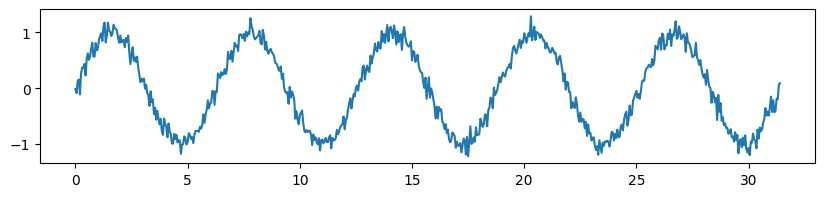

In [8]:
t = torch.arange(0, 10*torch.pi, 0.05)
y = torch.sin(t)
y.add_(torch.randn_like(y) * 0.1)
plt.figure(figsize=(10, 2))
plt.plot(t, y);

こんな感じの、ノイズの入ったsin波を学習データとする。

系列長は適当に100とする。固定。

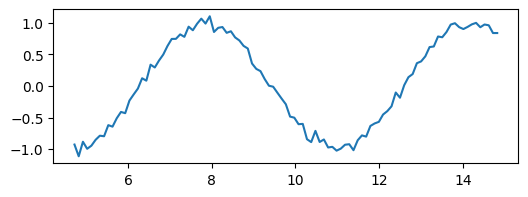

In [9]:
length = 100
n_samples = 10000
step_size = 0.1
noize_srd = 0.05

start = np.random.rand(n_samples) * 2 * np.pi
t = np.linspace(start, start + step_size * (length + 1), length + 1).T
samples = torch.sin(torch.tensor(t)).to(torch.float32)
samples.add_(torch.randn_like(samples) * noize_srd)
plt.figure(figsize=(6, 2))
plt.plot(t[0], samples[0]);

In [10]:
samples.shape

torch.Size([10000, 101])

In [11]:
x = samples[:, :-1].unsqueeze(-1)
y = samples[:, 1:].unsqueeze(-1)
x.shape, y.shape

(torch.Size([10000, 100, 1]), torch.Size([10000, 100, 1]))

In [12]:
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### モデル構築

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        y, _ = self.rnn(x)
        y = self.fc(y)
        return y

    @torch.no_grad()
    def gen_seq(self, x: torch.Tensor, seq_len: int) -> torch.Tensor:
        """
        シーケンスの生成。任意の長さのシーケンスを入力し、その続きを生成する。

        Args:
            x: 入力シーケンス。shape: (sequence_length, input_size)
            seq_len: 生成するシーケンスの長さ

        Returns:
            生成したシーケンス。shape: (seq_len, output_size)
        """

        self.eval()
        x.unsqueeze_(0) # バッチ次元の追加
        _, h = self.rnn(x) # 隠れ状態の初期値
        y = self.fc(h) # 最初の出力

        # 生成
        seq = [y[0]]
        for _ in range(seq_len - 1):
            _, h = self.rnn(y, h)
            y = self.fc(h)
            seq.append(y[0])

        return torch.tensor(seq)

In [14]:
def plot_gen_seq(model, figsize=(8, 4)):
    t = torch.arange(0, torch.pi, step_size)
    x = torch.sin(t)
    y = model.gen_seq(x.unsqueeze(-1), 100).squeeze()
    y = torch.cat([x, y])
    t_x = np.arange(len(x))
    t_y = np.arange(len(y))
    plt.figure(figsize=figsize)
    plt.plot(t_y, y, label='pred')
    plt.plot(t_x, x, label='input')
    plt.legend()

### 学習

In [15]:
criterion = nn.MSELoss()
def train(model, n_epochs, optimizer):
    model.train()
    for epoch in range(1, n_epochs + 1):
        for x, y in tqdm(dataloader, desc=f'Epoch {epoch}/{n_epochs}'):
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        print('loss:', loss.item(), '\n', flush=True)

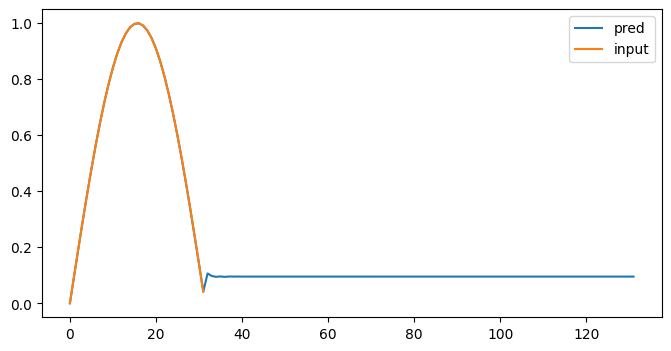

In [16]:
model = RNN(1, 32, 1)
plot_gen_seq(model)

In [17]:
model = RNN(1, 16, 1)
optimizer = optim.Adam(model.parameters())
train(model, 5, optimizer)

Epoch 1/5: 100%|██████████| 313/313 [00:01<00:00, 286.79it/s]

loss: 0.009523699060082436 




Epoch 2/5: 100%|██████████| 313/313 [00:01<00:00, 297.83it/s]

loss: 0.006782556883990765 




Epoch 3/5: 100%|██████████| 313/313 [00:01<00:00, 288.34it/s]

loss: 0.006416016723960638 




Epoch 4/5: 100%|██████████| 313/313 [00:01<00:00, 296.07it/s]

loss: 0.005671354476362467 




Epoch 5/5: 100%|██████████| 313/313 [00:01<00:00, 296.13it/s]

loss: 0.005415199790149927 



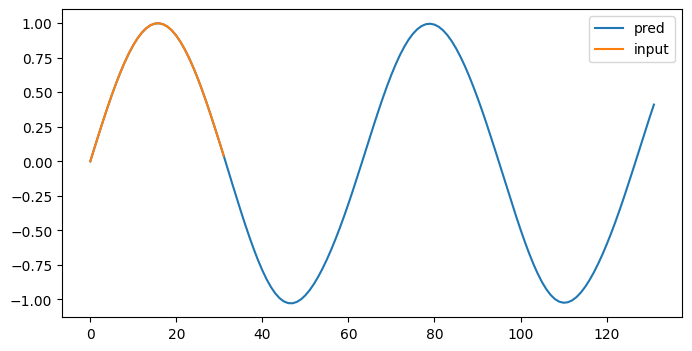

In [18]:
plot_gen_seq(model)